# Import packages and load functions

In [2]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd

In [3]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [4]:
#Load experimental data

# Periodic
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
periodic_time, periodic_data = syntheticdata

# Single pulse
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/singlepulse.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
single_time, single_data = syntheticdata

filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/Far1Constant.pickled'
with open(filename, 'rb') as f:
    Far1_arr = pickle.load(f)
Far1_time, Far1_data = Far1_arr

filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/MAPKdata.pickled'
with open(filename, 'rb') as f:
    MAPK_arr = pickle.load(f)
MAPK_time, MAPK_data = MAPK_arr

In [5]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [6]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            if t >= it*p+(p/2) and t < maxs/slope_off+(p)/2+p*it:
                return -slope_off*(t-it*p)+maxs+slope_off*p/2
            else:
                return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            if t >= p and t < maxs/slope_off+(p):
                return -slope_off*(t)+maxs+slope_off*p
            else:
                return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

In [7]:
# Set scoring functions
def scorefxn_constants(arr_parameters, time):
    scorefxn_data = single_data
    scorefxn_time = single_time
    mse_total = 0
    arr_params_IP = arr_parameters
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_params_IP
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 2
    
    ##### WT #####
    
    #### Single Pulse and Constant ####
    
    def DE(y,t,signal_number,slope_on,slope_off):
        GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y
        
        s=signal_periodic(signal_number,t,slope_on,slope_off)
        
        # GFP
        dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
        # Fus3
        dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
        # ppFus3
        dppFus3dt = kp1*s*Fus3-kp2*ppFus3
        # Ste12
        dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
        # Ste12Digs
        dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3)*Ste12Digs
        # Far1
        dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
        # pFar1
        dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1
        
        return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
    
    def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
        # parameters to be learned
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_parameters
        # parameters to be kept constant
        kdegGFP = 10**-1
        #solve odes:
        odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
        # return array of individual cell counts:
        return odes
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    # loop through different periods
    signal_numbers = [1]
    for i in range(len(signal_numbers)):
        expX = simulate_single_experiment1(arr_params_IP, time, signal_numbers[i],SS)
        
        if max(expX[:,0])<2:
            # get index of time points closest
            idx_closest_time_points = []
            for each_time in scorefxn_time[i]:
                closest_idx = min(range(len(time)),
                                  key = lambda i: abs(time[i] - each_time))
                idx_closest_time_points.append(closest_idx)

            # use indexes of time points to get data points to score against
            expX_scorefxn_data = expX[[idx_closest_time_points]]

            #SCORE IT! using MSE
            expX_mse = sum(np.abs(scorefxn_data[i] - expX_scorefxn_data[:,0]))
            #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
            mse_total += expX_mse

    ##### FAR1 DELETE #####
    
    kp4,ksynF1,ka5,kp3 = [0,0,0,0]
    mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]


    def DE(y,t,signal_number,slope_on,slope_off):
        GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y
        
        s=signal_periodic(signal_number,t,slope_on,slope_off)
        
        # GFP
        dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
        # Fus3
        dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
        # ppFus3
        dppFus3dt = kp1*s*Fus3-kp2*ppFus3
        # Ste12
        dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
        # Ste12Digs
        dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3)*Ste12Digs
        # Far1
        dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
        # pFar1
        dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1
    
        return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
    
    def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
        # parameters to be learned
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_parameters
        # parameters to be kept constant
        kdegGFP = 10**-1
        #solve odes:
        odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
        # return array of individual cell counts:
        return odes

    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]

    expX = simulate_single_experiment1(mut_params, time, 1,SS)
    # get index of time points closest
    idx_closest_time_points = []
    for each_time in [int(i) for i in Far1_time]:
        closest_idx = min(range(len(time)),
                          key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)

    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]
    
    #SCORE IT! using MSE
    expX_mse = sum(np.abs(Far1_data - expX_scorefxn_data[:,0]))
    
    mse_total += expX_mse
    
    return mse_total/(len(Far1_time)+len(scorefxn_time[0]))
def scorefxn_periodic(arr_parameters, time):
    scorefxn_data = periodic_data
    scorefxn_time = periodic_time
    mse_total = 0
    arr_params_IP = arr_parameters
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_params_IP
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 2
    
    ##### WT #####
    
    #### Single Pulse and Constant ####
    
    def DE(y,t,signal_number,slope_on,slope_off):
        GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y
        
        s=signal_single(signal_number,t,slope_on,slope_off)
        
        # GFP
        dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
        # Fus3
        dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
        # ppFus3
        dppFus3dt = kp1*s*Fus3-kp2*ppFus3
        # Ste12
        dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
        # Ste12Digs
        dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3)*Ste12Digs
        # Far1
        dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
        # pFar1
        dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1
        
        return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
    
    def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
        # parameters to be learned
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_parameters
        # parameters to be kept constant
        kdegGFP = 10**-1
        #solve odes:
        odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
        # return array of individual cell counts:
        return odes
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    # loop through different periods

    #### Periodic ####

    def DE(y,t,signal_number,slope_on,slope_off):
        GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y
        
        s=signal_periodic(signal_number,t,slope_on,slope_off)
        
        # GFP
        dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
        # Fus3
        dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
        # ppFus3
        dppFus3dt = kp1*s*Fus3-kp2*ppFus3
        # Ste12
        dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
        # Ste12Digs
        dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3)*Ste12Digs
        # Far1
        dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
        # pFar1
        dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1
        
        return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]

    def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
        # parameters to be learned
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_parameters
        # parameters to be kept constant
        kdegGFP = 10**-1
        #solve odes:
        odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
        # return array of individual cell counts:
        return odes

    # loop through different periods
    signal_numbers = [90,120,150,180,240,320]
    for i in range(len(signal_numbers)):
        expX = simulate_single_experiment1(arr_params_IP, time, signal_numbers[i],SS)
        
        if max(expX[:,0])<2:
        
            # get index of time points closest
            idx_closest_time_points = []
            for each_time in periodic_time[i+1]:
                closest_idx = min(range(len(time)),
                                  key = lambda i: abs(time[i] - each_time))
                idx_closest_time_points.append(closest_idx)

            # use indexes of time points to get data points to score against
            expX_scorefxn_data = expX[[idx_closest_time_points]]

            #SCORE IT! using MSE
            expX_mse = sum(np.abs(periodic_data[i+1] - expX_scorefxn_data[:,0]))
            #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
        mse_total += expX_mse
    
    return mse_total/(len(scorefxn_data[0]+periodic_data[1]+periodic_data[2]+periodic_data[3]+periodic_data[4]+periodic_data[5]+periodic_data[6]))
def scorefxn_pulses(arr_parameters, time):
    scorefxn_data = single_data
    scorefxn_time = single_time
    mse_total = 0
    arr_params_IP = arr_parameters
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_params_IP
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 2
    
    ##### WT #####
    
    #### Single Pulse and Constant ####
    
    def DE(y,t,signal_number,slope_on,slope_off):
        GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y
        
        s=signal_single(signal_number,t,slope_on,slope_off)
        
        # GFP
        dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
        # Fus3
        dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
        # ppFus3
        dppFus3dt = kp1*s*Fus3-kp2*ppFus3
        # Ste12
        dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
        # Ste12Digs
        dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3)*Ste12Digs
        # Far1
        dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
        # pFar1
        dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1
        
        return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
    
    def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
        # parameters to be learned
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_parameters
        # parameters to be kept constant
        kdegGFP = 10**-1
        #solve odes:
        odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
        # return array of individual cell counts:
        return odes
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    # loop through different periods
    signal_numbers = [1,45,60,75,90,160]
    for i in range(len(signal_numbers)):
        expX = simulate_single_experiment1(arr_params_IP, time, signal_numbers[i],SS)
        
        if max(expX[:,0])<2:
        
            # get index of time points closest
            idx_closest_time_points = []
            for each_time in scorefxn_time[i]:
                closest_idx = min(range(len(time)),
                                  key = lambda i: abs(time[i] - each_time))
                idx_closest_time_points.append(closest_idx)

            # use indexes of time points to get data points to score against
            expX_scorefxn_data = expX[[idx_closest_time_points]]

            #SCORE IT! using MSE
            expX_mse = sum(np.abs(scorefxn_data[i] - expX_scorefxn_data[:,0]))
            #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
            mse_total += expX_mse

    return mse_total/(len(scorefxn_data[0])+len(scorefxn_data[1])+len(scorefxn_data[2])+len(scorefxn_data[3])
                      +len(scorefxn_data[4])+len(scorefxn_data[5])+len(scorefxn_data[6]))

# Fit to constant (WT only)

In [ ]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Reduced parameter ranges/180709_ConstantOnly_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,0.0277)
arrT_best_inds_P = arr_best_inds_P.transpose()

In [ ]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.6]
    maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,0,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
#     #SAVING FIGURES CODE:
#     #filename:
#     if gen < 10:
#         filename = 'top19_170608_image_00' + str(gen)
#     elif 10 <= gen < 100:
#         filename = 'top19_170608_image_0' + str(gen)
#     else:
#         filename = 'top19_170708_image_' + str(gen)

    fig.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/ConstantWT.pdf')

In [ ]:
# Bar Plot
sns.set_context("talk")
gen = 100
constant_err = []
periodic_err = []
pulse_err = []
for j in range(len(arr_best_inds_P[:,gen])):
    constant_err.append(scorefxn_constants(arr_best_inds_P[j][gen],time))
    periodic_err.append(scorefxn_periodic(arr_best_inds_P[j][gen],time))
    pulse_err.append(scorefxn_pulses(arr_best_inds_P[j][gen],time))
errs = pd.DataFrame({'Constant' : constant_err, 
                     'Single Pulse' : pulse_err,
                     'Periodic':periodic_err})
sns.boxplot(errs)
plt.title("Fit to constant WT only data")
plt.ylabel("Average absolute error")
plt.ylim([0,0.3])
plt.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/ConstantWT_bar.pdf')

# Fit to constant (WT and Far1$\Delta$)

In [ ]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Reduced parameter ranges/180709_Constants_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,0.104)
arrT_best_inds_P = arr_best_inds_P.transpose()

In [ ]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.6]
    maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,0,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
#     #SAVING FIGURES CODE:
#     #filename:
#     if gen < 10:
#         filename = 'top19_170608_image_00' + str(gen)
#     elif 10 <= gen < 100:
#         filename = 'top19_170608_image_0' + str(gen)
#     else:
#         filename = 'top19_170708_image_' + str(gen)

fig.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/Constants.pdf')

In [ ]:
# Bar Plot
sns.set_context("talk")
gen = 100
constant_err = []
periodic_err = []
pulse_err = []
for j in range(len(arr_best_inds_P[:,gen])):
    constant_err.append(scorefxn_constants(arr_best_inds_P[j][gen],time))
    periodic_err.append(scorefxn_periodic(arr_best_inds_P[j][gen],time))
    pulse_err.append(scorefxn_pulses(arr_best_inds_P[j][gen],time))
errs = pd.DataFrame({'Constant' : constant_err, 
                     'Single Pulse' : pulse_err,
                     'Periodic':periodic_err})
sns.boxplot(errs)
plt.title("Fit to constant data")
plt.ylabel("Average absolute error")
plt.ylim([0,0.3])
plt.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/Constants_bar.pdf')

# Fit to single pulse and constant data

In [ ]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Reduced parameter ranges/180710_SinglePulse_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,0.472)
arrT_best_inds_P = arr_best_inds_P.transpose()

In [ ]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.6]
    maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,0,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
#     #SAVING FIGURES CODE:
#     #filename:
#     if gen < 10:
#         filename = 'top19_170608_image_00' + str(gen)
#     elif 10 <= gen < 100:
#         filename = 'top19_170608_image_0' + str(gen)
#     else:
#         filename = 'top19_170708_image_' + str(gen)

fig.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/SinglePulse.pdf')

In [ ]:
# Bar Plot
sns.set_context("talk")
gen = 100
constant_err = []
periodic_err = []
pulse_err = []
for j in range(len(arr_best_inds_P[:,gen])):
    constant_err.append(scorefxn_constants(arr_best_inds_P[j][gen],time))
    periodic_err.append(scorefxn_periodic(arr_best_inds_P[j][gen],time))
    pulse_err.append(scorefxn_pulses(arr_best_inds_P[j][gen],time))
errs = pd.DataFrame({'Constant' : constant_err, 
                     'Single Pulse' : pulse_err,
                     'Periodic':periodic_err})
sns.boxplot(errs)
plt.title("Fit to single pulse and constant data")
plt.ylabel("Average absolute error")
plt.ylim([0,0.3])
plt.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/SinglePulse_bar.pdf')

# Fit to periodic and constant data

In [ ]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Reduced parameter ranges/180710_Periodic_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,0.703)
arrT_best_inds_P = arr_best_inds_P.transpose()

In [ ]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.6]
    maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,0,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
#     #SAVING FIGURES CODE:
#     #filename:
#     if gen < 10:
#         filename = 'top19_170608_image_00' + str(gen)
#     elif 10 <= gen < 100:
#         filename = 'top19_170608_image_0' + str(gen)
#     else:
#         filename = 'top19_170708_image_' + str(gen)

fig.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/Periodic.pdf')

In [ ]:
# Bar Plot
sns.set_context("talk")
gen = 100
constant_err = []
periodic_err = []
pulse_err = []
for j in range(len(arr_best_inds_P[:,gen])):
    constant_err.append(scorefxn_constants(arr_best_inds_P[j][gen],time))
    periodic_err.append(scorefxn_periodic(arr_best_inds_P[j][gen],time))
    pulse_err.append(scorefxn_pulses(arr_best_inds_P[j][gen],time))
errs = pd.DataFrame({'Constant' : constant_err, 
                     'Single Pulse' : pulse_err,
                     'Periodic':periodic_err})
sns.boxplot(errs)
plt.title("Fit to Periodic and Constant Data")
plt.ylabel("Average absolute error")
plt.ylim([0,0.3])
plt.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/Periodic_bar.pdf')

# Fit to all data

In [18]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181025_AllDatav2_100g500i10m50c/'
arr_best_scores_P, arr_end_scores_P, arr_best_inds_P=load_data(directory,1.08)
arrT_best_inds_P = arr_best_inds_P.transpose()

Loaded 21 files (out of 872) with cutoff score of 1.08


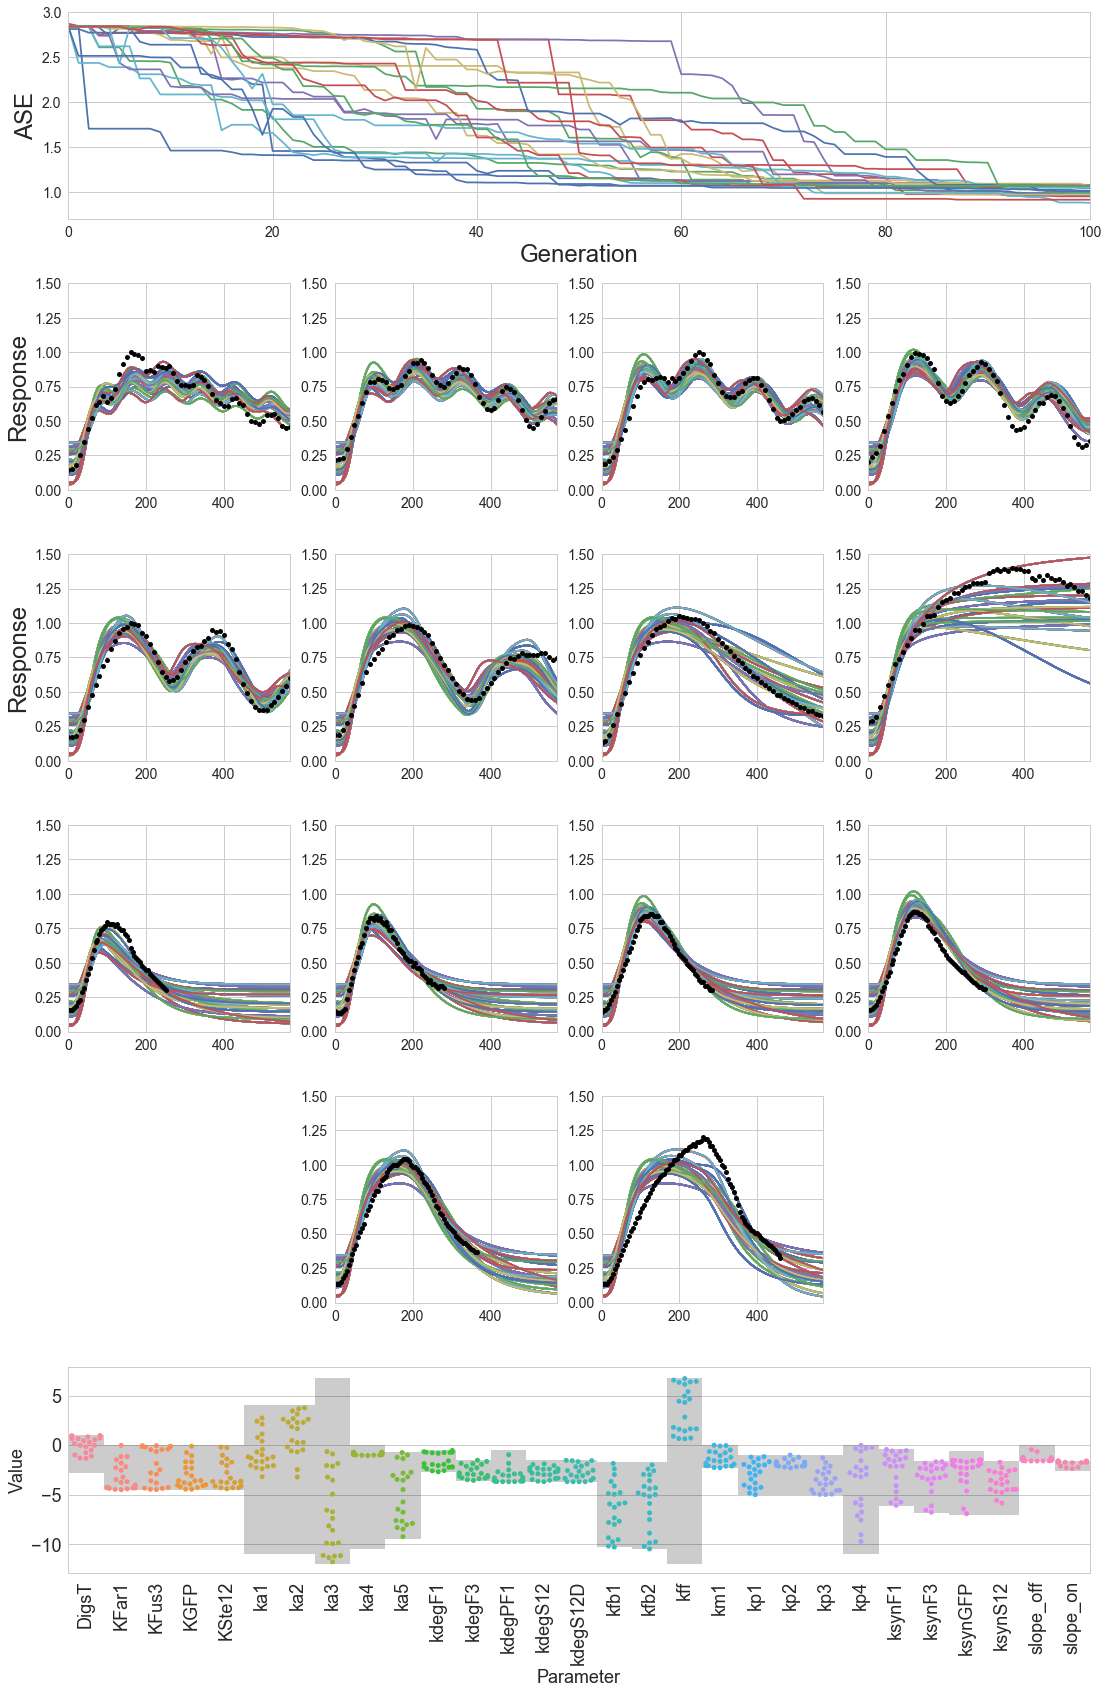

In [19]:
# Generate figure
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]
for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' kdegPF1':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' ksynF3':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[2],  
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kff':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' slope on':np.log10(arr_best_inds_P[i][gen])[22],
                   ' slope off':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[25], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[26], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[27],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[28]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
    #7 part plot
    fig = plt.figure(figsize=(16, 24))
    gs = gridspec.GridSpec(6,4)
    ax1 = fig.add_subplot(gs[0,:])
    ax21 = fig.add_subplot(gs[1,0])
    ax22 = fig.add_subplot(gs[1,1])
    ax23 = fig.add_subplot(gs[1,2])
    ax24 = fig.add_subplot(gs[1,3])
    ax25 = fig.add_subplot(gs[2,0])
    ax26 = fig.add_subplot(gs[2,1])
    ax27 = fig.add_subplot(gs[2,2])
    ax28 = fig.add_subplot(gs[2,3])
    ax31 = fig.add_subplot(gs[3,0])
    ax32 = fig.add_subplot(gs[3,1])
    ax33 = fig.add_subplot(gs[3,2])
    ax34 = fig.add_subplot(gs[3,3])
    ax41 = fig.add_subplot(gs[4,1])
    ax42 = fig.add_subplot(gs[4,2])
    ax3 = fig.add_subplot(gs[5,:])
    ax = fig.add_subplot(gs[:,:])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_facecolor('none')
    ax.grid('off')

    ax1.set_xlabel('Generation', fontsize=24)
    ax1.set_ylabel('ASE', fontsize=24)
    ax21.set_ylabel('Response', fontsize=24)
    ax25.set_ylabel('Response', fontsize=24)

    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    #PLOT ERROR VS. GENERATION 
    for i in range(len(arr_best_scores_P)):
        ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1])
    ax1.set_xlim([0,100])
    ax1.set_ylim([0.7,3.0])
    
    #DEFINE STEADY STATE - WT
    SS=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
        
    #DEFINE STEADY STATE - MUTANT
    SS_mut=[]
    for j in range(len(arr_best_inds_P[:,gen])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
        kp4,ksynF1,ka5,kp3 = [0,0,0,0]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS_mut.append(odes[100000,:])
        
    #LOOP THROUGH EA RUNS
    for arr_best_score, arr_best_ind in zip(arr_best_scores_P, arr_best_inds_P):
        for j in range(len(arr_best_inds_P[:,gen])):
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds_P[j][gen]
            for i in [1,90,120,150,180,240,320]:
                expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 1:
                    ax27.plot(time, expX[:,0])
                elif i == 90:
                    ax21.plot(time, expX[:,0])
                elif i == 120: 
                    ax22.plot(time, expX[:,0])
                elif i == 150: 
                    ax23.plot(time, expX[:,0])
                elif i == 180:
                    ax24.plot(time, expX[:,0])
                elif i == 240:
                    ax25.plot(time, expX[:,0])
                elif i == 320: 
                    ax26.plot(time, expX[:,0])
            for i in [45,60,75,90,160,250]:
                expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
                if i == 45:
                    ax31.plot(time, expX[:,0])
                elif i == 60:
                    ax32.plot(time, expX[:,0])
                elif i == 75: 
                    ax33.plot(time, expX[:,0])
                elif i == 90: 
                    ax34.plot(time, expX[:,0])
                elif i == 160:
                    ax41.plot(time, expX[:,0])
                elif i == 250:
                    ax42.plot(time, expX[:,0])
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            mut_params = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D]
            for i in [1]:
                expX = simulate_periodic_experiment(mut_params, time, i,SS[j])
                ax28.plot(time, expX[:,0])
                
                
    #plot experimental data:
    scorefxn_time = periodic_time
    scorefxn_data = periodic_data
    ax21.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax21.axis([0, 570, 0, 1.5])
    ax22.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax22.axis([0, 570, 0, 1.5])
    ax23.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax23.axis([0, 570, 0, 1.5])
    ax24.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax24.axis([0, 570, 0, 1.5])
    ax25.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax25.axis([0, 570, 0, 1.5])
    ax26.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax26.axis([0, 570, 0, 1.5])
    ax27.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=5)
    ax27.axis([0, 570, 0, 1.5])
    ax28.plot(Far1_time, Far1_data, 'ko', markersize=5)
    ax28.axis([0, 570, 0, 1.5])
    
    scorefxn_time = single_time
    scorefxn_data = single_data
    ax31.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=5)
    ax31.axis([0, 570, 0, 1.5])
    ax32.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=5)
    ax32.axis([0, 570, 0, 1.5])
    ax33.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=5)
    ax33.axis([0, 570, 0, 1.5])
    ax34.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=5)
    ax34.axis([0, 570, 0, 1.5])
    ax41.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=5)
    ax41.axis([0, 570, 0, 1.5])
    ax42.plot(scorefxn_time[6], scorefxn_data[6], 'ko', markersize=5)
    ax42.axis([0, 570, 0, 1.5])

    
    labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_off', 'slope_on']
    from pylab import *
    g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3)
    g.set_xticklabels(labelnames,rotation=90)
    mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-1.6,-2.6]
    maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,0,-1.6]
    for i in range(len(mins)):
        ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)


    gs.tight_layout(fig)
    
#     #SAVING FIGURES CODE:
#     #filename:
#     if gen < 10:
#         filename = 'top19_170608_image_00' + str(gen)
#     elif 10 <= gen < 100:
#         filename = 'top19_170608_image_0' + str(gen)
#     else:
#         filename = 'top19_170708_image_' + str(gen)


In [ ]:
# Bar Plot
sns.set_context("talk")
gen = 100
constant_err = []
periodic_err = []
pulse_err = []
for j in range(len(arr_best_inds_P[:,gen])):
    constant_err.append(scorefxn_constants(arr_best_inds_P[j][gen],time))
    periodic_err.append(scorefxn_periodic(arr_best_inds_P[j][gen],time))
    pulse_err.append(scorefxn_pulses(arr_best_inds_P[j][gen],time))
errs = pd.DataFrame({'Constant' : constant_err, 
                     'Single Pulse' : pulse_err,
                     'Periodic':periodic_err})
sns.boxplot(errs)
plt.title("Fit to all data")
plt.ylabel("Average absolute error")
plt.ylim([0,0.25])
plt.savefig('/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Figures/Presentations/All_bar.pdf')

# Determining the mechanism of memory
## Abundance of Digs

In [ ]:
# Generate figure
import operator
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]

#DEFINE STEADY STATE - WT
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)

#LOOP THROUGH EA RUNS
single_maxes_mut = np.zeros([len(arr_best_inds_P[:,100]),5])
for idx, j in enumerate([0.01,0.1,1,10,100]):
    for k in range(len(arr_best_inds_P[:,100])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[k][100]
        DigsT = DigsT*j
        ind = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
        odes = simulate_singlepulse_experiment(ind, t, 0,IC)
        SS=odes[100000,:]
        for i in [45]:
            expX = simulate_singlepulse_experiment(ind, time, i,SS)
            max_index, max_value = max(enumerate(expX[:,0]), key=operator.itemgetter(1))
            single_maxes_mut[k,idx]=(max_index)
DigsT_effect = pd.DataFrame(single_maxes_mut, columns=['100 fold decrease','10 fold decrease','no change','10 fold increase','100 fold increase'])
DigsT_effect_scaled = DigsT_effect.divide(median(DigsT_effect['no change']))
sns.boxplot(DigsT_effect_scaled)

## Effect of Far1 dependent degredation of Ste12

In [ ]:
# Generate figure
import operator
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]

#DEFINE STEADY STATE - WT
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)

#LOOP THROUGH EA RUNS
single_maxes_mut = np.zeros([len(arr_best_inds_P[:,100]),5])
for idx, j in enumerate([0.01,0.1,1,10,100]):
    for k in range(len(arr_best_inds_P[:,100])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[k][100]
        kff = kff*j
        ind = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
        odes = simulate_singlepulse_experiment(ind, t, 0,IC)
        SS=odes[100000,:]
        for i in [45]:
            expX = simulate_singlepulse_experiment(ind, time, i,SS)
            max_index, max_value = max(enumerate(expX[:,0]), key=operator.itemgetter(1))
            single_maxes_mut[k,idx]=(max_index)
kff_effect = pd.DataFrame(single_maxes_mut, columns=['100 fold decrease','10 fold decrease','no change','10 fold increase','100 fold increase'])
kff_effect_scaled = kff_effect.divide(median(kff_effect['no change']))
sns.boxplot(kff_effect_scaled)

## Effect of positive feedback on Ste12

In [ ]:
# Generate figure
import operator
kdegGFP = 10**-1
hc = 2
time = np.linspace(0,830,831)
signal_numbers = [1]

#DEFINE STEADY STATE - WT
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)

#LOOP THROUGH EA RUNS
single_maxes_mut = np.zeros([len(arr_best_inds_P[:,100]),5])
for idx, j in enumerate([0.01,0.1,1,10,100]):
    for k in range(len(arr_best_inds_P[:,100])):
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds_P[k][100]
        kfb2 = kfb2*j
        ind = [kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1]
        odes = simulate_singlepulse_experiment(ind, t, 0,IC)
        SS=odes[100000,:]
        for i in [45]:
            expX = simulate_singlepulse_experiment(ind, time, i,SS)
            max_index, max_value = max(enumerate(expX[:,0]), key=operator.itemgetter(1))
            single_maxes_mut[k,idx]=(max_index)
kfb2_effect = pd.DataFrame(single_maxes_mut, columns=['100 fold decrease','10 fold decrease','no change','10 fold increase','100 fold increase'])
kfb2_effect_scaled = kfb2_effect.divide(median(kfb2_effect['no change']))
sns.boxplot(kfb2_effect_scaled)

## Looking at them all together

In [ ]:
unstacked[unstacked['Parameter']==' kdegS12']

In [27]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Reduced parameter ranges/180703_AllData_100g500i10m50c/'
arr_best_scores, arr_end_scores, arr_best_inds=load_data(directory,1.115)
arrT_best_inds = arr_best_inds.transpose()

Loaded 64 files (out of 1288) with cutoff score of 1.115


NameError: name 'DE' is not defined

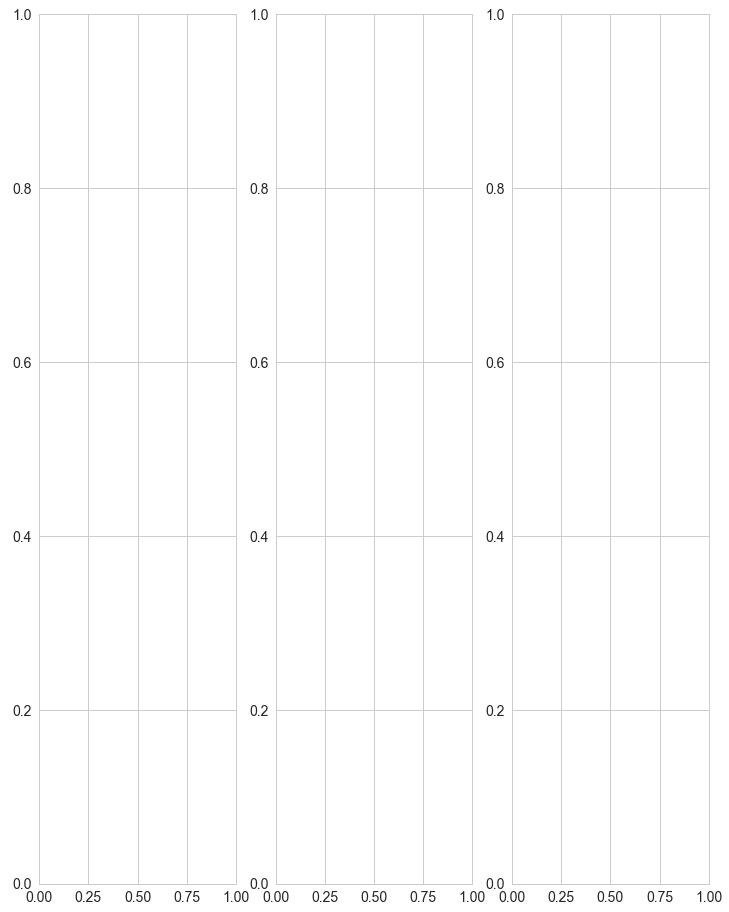

In [26]:
#Specify Figure
hc =2
fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,300,3000)
kdegS12D = 0

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)

for j in range(len(arr_best_inds[:,gen])):
    for i in range(7):
        expX = 0
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1 = arr_best_inds[j][gen]
        if i == 0:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1=curr_params
            odes = odeint(DE, IC, t, args=(0,100,100,))
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax11.plot(t1,expX[:,0])
            ax11.plot(np.linspace(0,len(BY68_pulse)*5,len(BY68_pulse)),BY68_pulse,'ko')
            ax11.set_title('WT')
            ax11.set_ylim([0,1.3])
        elif i == 5:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, 0, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax31.plot(t1,expX[:,0])
            ax31.plot(np.linspace(0,len(BY147_pulse_scaled)*5,len(BY147_pulse_scaled)),BY147_pulse_scaled,'ko')
            ax31.set_title('Dig1$\Delta$Dig2$\Delta$')
            ax31.set_ylim([0,2.0])
        elif i == 6:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP*3.33, KFus3, KSte12, KFar1
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 90,SS)
            ax32.plot(t1,expX[:,0])
            ax32.plot(np.linspace(0,len(BY169_pulse_scaled)*5,len(BY169_pulse_scaled)),BY169_pulse_scaled,'ko')
            ax32.set_title('PRE*-GFP')
            ax32.set_ylim([0,1.3])